In [1]:
!pip install trackpy >/dev/null
!pip install nplocate >/dev/null
import numpy as np
import trackpy as tp
import nplocate as nl
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.spatial.distance import cdist

# How nplocate works

This notebook walks through the general steps that `nplocate` took

## Generate initial tracking results

firsty, we use a existing tracking code `trackpy` to perform the tracking procedure

In [2]:
diameter = 11

img = np.load('image.npy')
xyz = tp.locate(img, diameter=diameter)
xyz = np.array(xyz)[:, :3]
xyz_tp = xyz.copy()

## Measure the shape of particles

then, we measure the average shape of the particles from the tracked results

we have to assume the radius of the shape. Since the image is highly distorted along the z-axis, we will make the box quite big to enclose a entire particle

The model shape is a 2D gaussian function. Where the X and Y component is assumed to be identical, and the Z axis is significantly elongated.

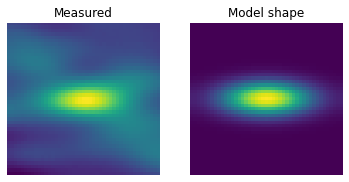

In [3]:
r_model = 2 * diameter
model, measure = nl.utility.get_model(img, xyz, r_model, want_measure=True)

plt.subplot(121).imshow(measure.mean(0))
plt.title("Measured")
plt.axis('off')
plt.subplot(122).imshow(model.mean(0))
plt.title("Model shape")
plt.axis('off')
plt.show()

## Calculate the difference Image

With the model and the positions, we can <big><font color="teal">simulate</font></big> an image now, and compare it with the real image.

Their <big><font color="teal">difference</font></big> will reveal the missing particles for us.

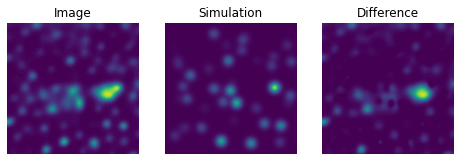

In [4]:
simulation = nl.simulate(xyz.astype(int), model, img)
diff = img - simulation
diff -= diff.min()

plt.subplot(131).imshow(img[:, :, 10], vmin=0, vmax=img.max())
plt.title('Image')
plt.axis('off')
plt.subplot(132).imshow(simulation[:, :, 10], vmin=0, vmax=img.max())
plt.title('Simulation')
plt.axis('off')
plt.subplot(133).imshow((img - simulation)[:, :, 10], vmin=0, vmax=img.max())
plt.title('Difference')
plt.axis('off')
plt.gcf().set_size_inches(8, 3)
plt.show()

## Find missing particles

Now we track the particles in the difference map, and add them into our tracking result

The new tracking result is name `xyz_new`. We will remove particles in `xyz_new` if they overlap with previous found particles

In [9]:
print("before search the difference", len(xyz), "particles")
xyz_new = np.array(tp.locate(diff, diameter, preprocess=True))[:, :3]
dists = cdist(xyz_new, xyz)
not_overlap = np.min(dists, axis=1) > diameter
xyz = np.concatenate((xyz, xyz_new[not_overlap]), axis=0)
print("after search the difference", len(xyz), "particles, updating the model & difference map")
model = nl.utility.get_model(img, xyz, r_model, want_measure=False)
simulation = nl.simulate(xyz.astype(int), model, img)
diff = img - simulation

before search the difference 301 particles
after search the difference 301 particles, updating the model & difference map


In practical locating, I will repeat the above recursively untill no more particles can be found.

In the current notebook, just <big><font color="teal">keeps running the above cell</font></big> until you get a stable result


## Optimise the particle positions

now we calculate the some quantities for minimising the difference between the simulated image and the real image. They include,

1. numerical derivative of the model w.r.t. to different axes for the Jacobian matrix
2. the bounds of all the variables
3. the canvas to draw the image and the simulation

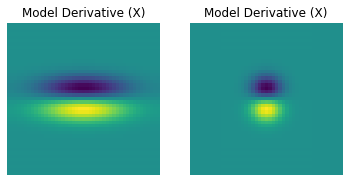

In [10]:
model_der = nl.utility.get_model_derivitives(model)
bounds = nl.utility.get_position_bounds(xyz, img)
radii = ((np.array(model.shape) - 1) / 2).astype(int)
canvas_img, canvas = nl.utility.get_canvases(img, radii)

plt.subplot(121).imshow(model_der[0][:, model.shape[1]//2])
plt.title("Model Derivative (X)")
plt.xlabel("Z")
plt.xlabel("X")
plt.axis('off')
plt.subplot(122).imshow(model_der[0][:, :, model.shape[2]//2])
plt.title("Model Derivative (X)")
plt.xlabel("X")
plt.xlabel("Y")
plt.axis('off')
plt.show()

Now we have everything and we will refine our positions with the numerical optimiser. If you are interested in the process, take a look at the function `r_cost` and `r_jac`.

In [11]:
res = minimize(
    fun=nl.utility.r_cost,
    jac=nl.utility.r_jac,
    x0=xyz.ravel(),
    method='L-BFGS-B',
    args=(model, model_der, canvas_img, canvas, radii),
    bounds=bounds,
    tol=1,
    options={'maxiter': 100}
)

print(res.message, res.nfev)
opt = np.reshape(res.x, xyz.shape)

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH' 6


The minimization works, great! Now let's resolve the overlapped particles.

I will find all overlapping particles and just keep the brightest one.

In [12]:
print("before remove overlap", len(opt), "particles")
opt = nl.utility.remove_overlap(opt, img, diameter)
print("after remove overlap", len(opt), "particles")

before remove overlap 301 particles
after remove overlap 279 particles


## Final Result

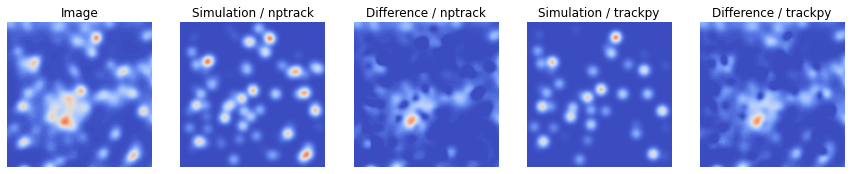

In [13]:
simulation = nl.simulate(opt.astype(int), model, img)
simulation_tp = nl.simulate(xyz_tp.astype(int), model, img)
diff = img - simulation
diff_tp = img - simulation_tp

axis = 2
s = 30

box = [slice(0, img.shape[d]) for d in range(3)]
box[axis] = s
box = tuple(box)
plt.subplot(151).imshow(img[box], vmin=0, vmax=img.max()/2, cmap='coolwarm')
plt.title('Image')
plt.axis('off')
plt.subplot(152).imshow(simulation[box], vmin=0, vmax=img.max()/2, cmap='coolwarm')
plt.title('Simulation / nptrack')
plt.axis('off')
plt.subplot(153).imshow(diff[box], vmin=-img.max()/2, vmax=img.max()/2, cmap='coolwarm')
plt.title('Difference / nptrack')
plt.axis('off')
plt.subplot(154).imshow(simulation_tp[box], vmin=0, vmax=img.max()/2, cmap='coolwarm')
plt.title('Simulation / trackpy')
plt.axis('off')
plt.subplot(155).imshow(diff_tp[box], vmin=-img.max()/2, vmax=img.max()/2, cmap='coolwarm')
plt.title('Difference / trackpy')
plt.axis('off')
plt.gcf().set_size_inches(15, 3)
plt.show()

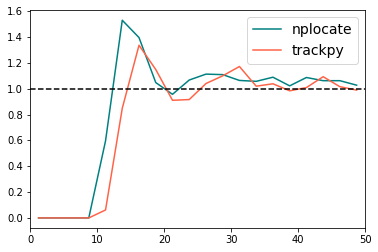

In [14]:
gr_opt = nl.get_gr(opt, 50, 21, 2e4)
gr_tp = nl.get_gr(xyz_tp, 50, 21, 2e4)
plt.plot(*gr_opt, color='teal', label='nplocate')
plt.plot(*gr_tp, color='tomato', label='trackpy')
plt.plot((0, 50), (1, 1), color='k', ls='--')
plt.xlim(0, 50)
plt.legend(fontsize=14)
plt.show()